# Time series forcasting

Hourly energy consumption dataset
- Video: https://www.youtube.com/watch?v=vV12dGe_Fho&ab_channel=RobMulla

Stationary or non-stationary data

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit


In [114]:
df = pd.read_csv("./PJME_hourly.csv",index_col=0)
df.index = pd.to_datetime(df.index)
#df.set_index("Datetime")
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [115]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


<AxesSubplot: xlabel='Datetime'>

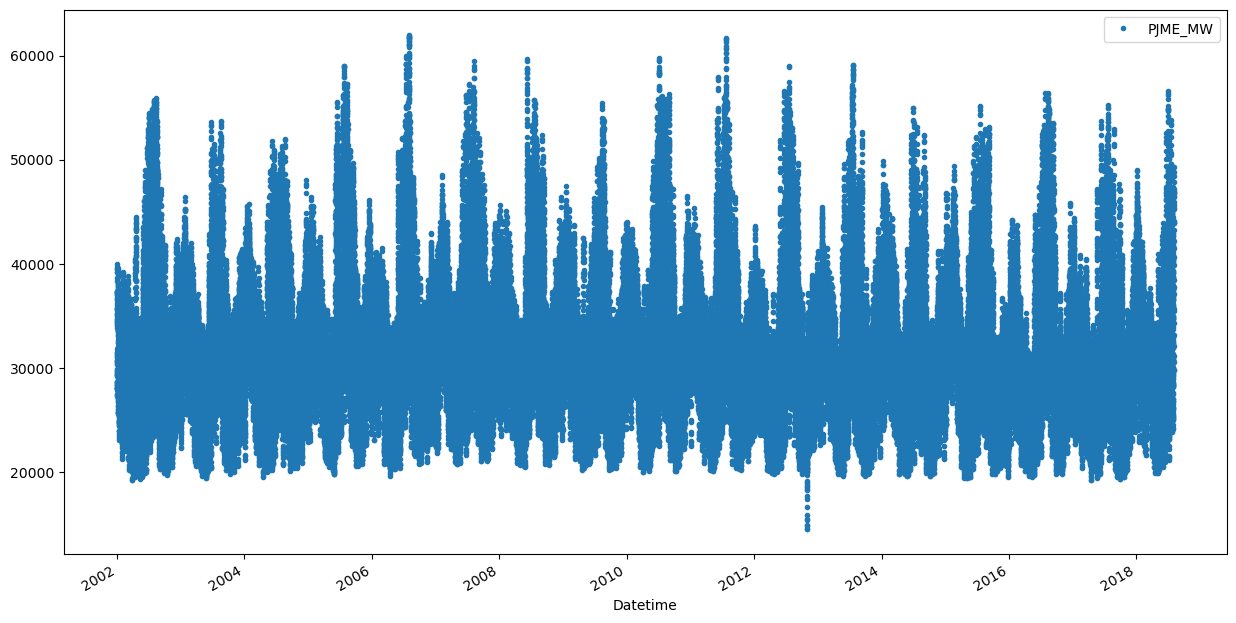

In [116]:
color_pal = sns.color_palette()
df.plot(style='.',figsize=(15,8),color=color_pal[0])

<AxesSubplot: xlabel='Datetime'>

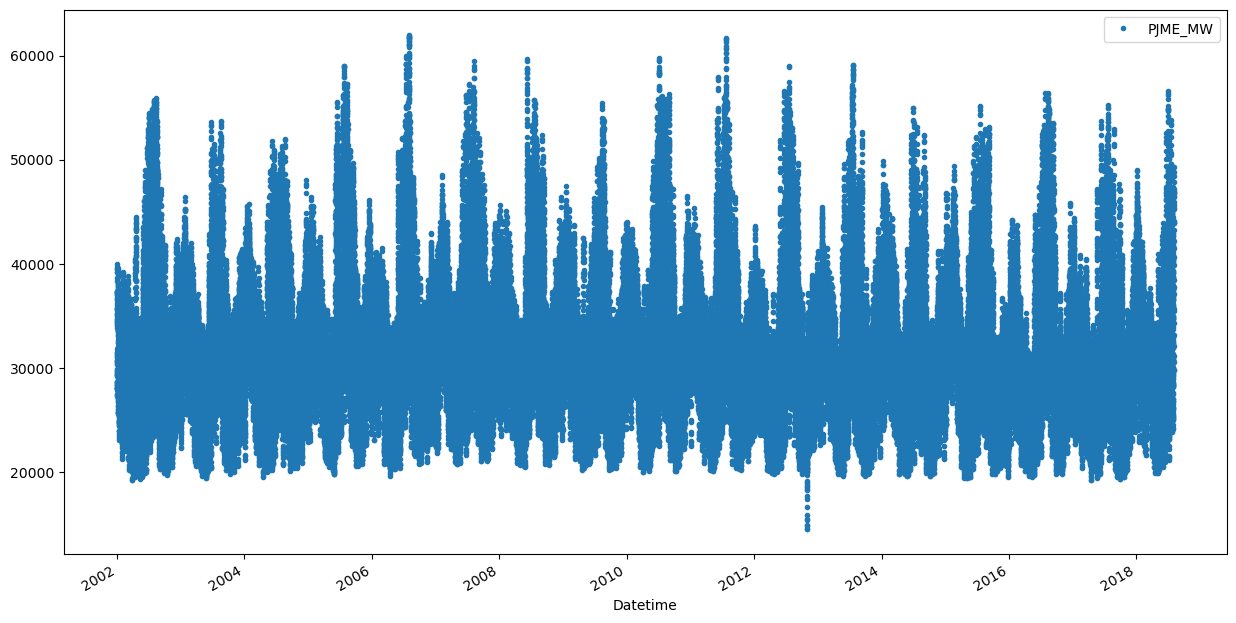

In [117]:
# Datatime index is an object, so we need to convert to
df.index = pd.to_datetime(df.index)
df.plot(style='.',figsize=(15,8),color=color_pal[0])

# Train / Test split
(Avoiding cross validation)


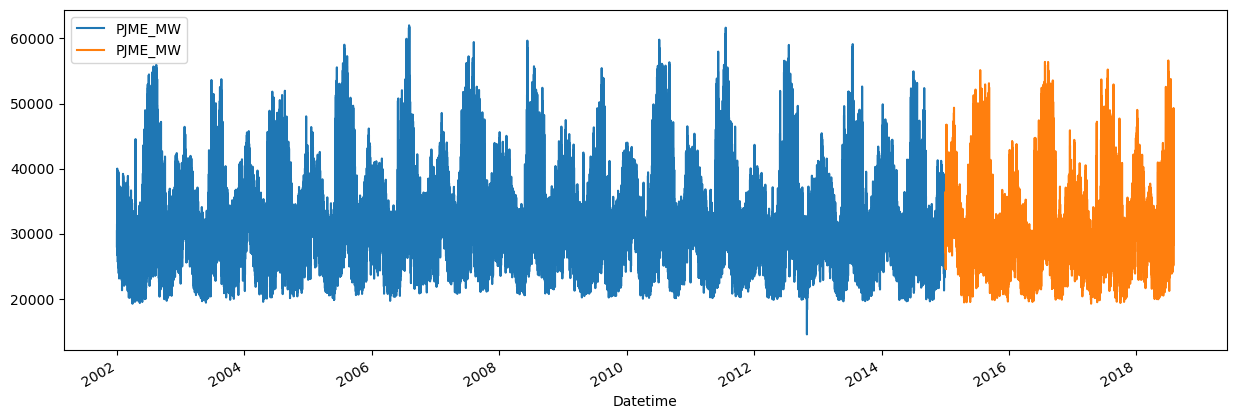

In [118]:
train = df.loc[df.index < "01-01-2015"]
test = df.loc[df.index > "01-01-2015"]

fig,ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax,label="train",color=color_pal[0])
test.plot(ax=ax,label="test",color=color_pal[1])
plt.legend()
plt.show()

# Analyze one week of data

<AxesSubplot: xlabel='Datetime'>

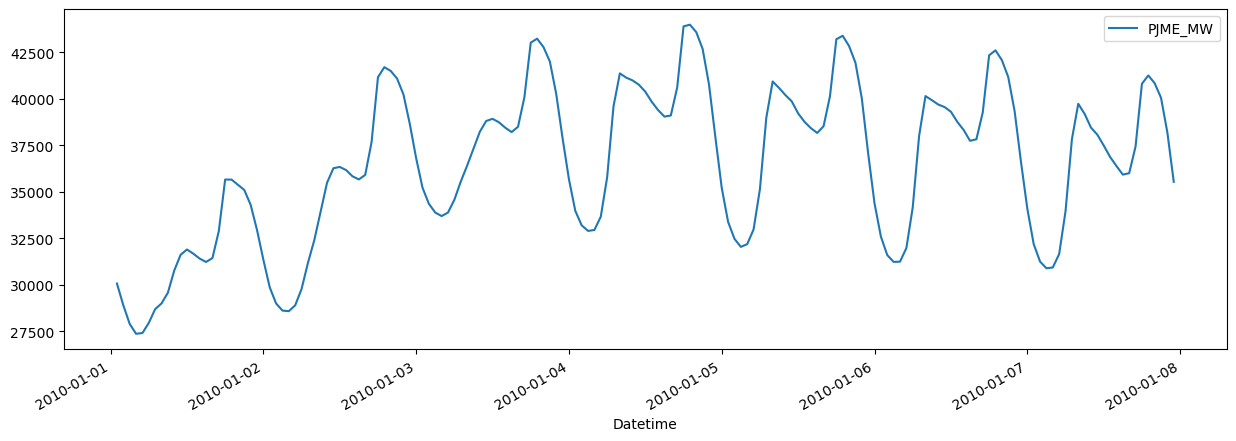

In [119]:
df_week = df.loc[((df.index > "01-01-2010") & (df.index < "01-08-2010"))]
df_week.plot(figsize=(15,5))

## Observation:  
Variations found within a given day
(Two peaks are common for energy consumption) & Weekend effect

# Feature Creation

In [120]:
def create_features(df):
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.day_of_week
    #df["week"] = df.index.week
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["quarter"] = df.index.quarter
    df["dayofyear"] = df.index.day_of_year
    df["weakofyear"] = df.index.isocalendar()
    return df
df = create_features(df)

# Plot the feature to target relation
Using box plot (show distribution of the dataset)


Text(0.5, 1.0, 'MW by hour')

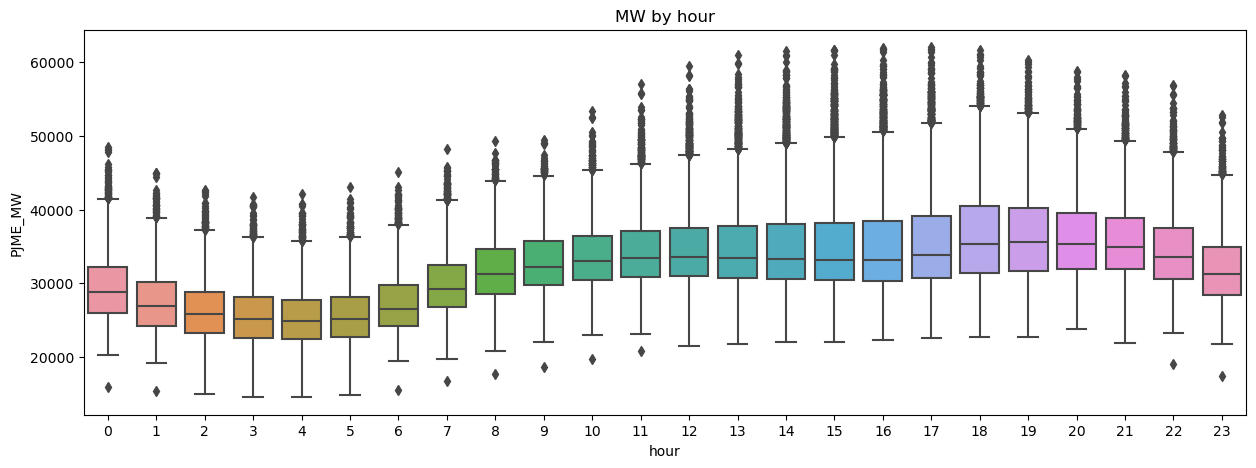

In [121]:
fig,ax=plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x="hour",y="PJME_MW")
ax.set_title("MW by hour")

Text(0.5, 1.0, 'MW by hour')

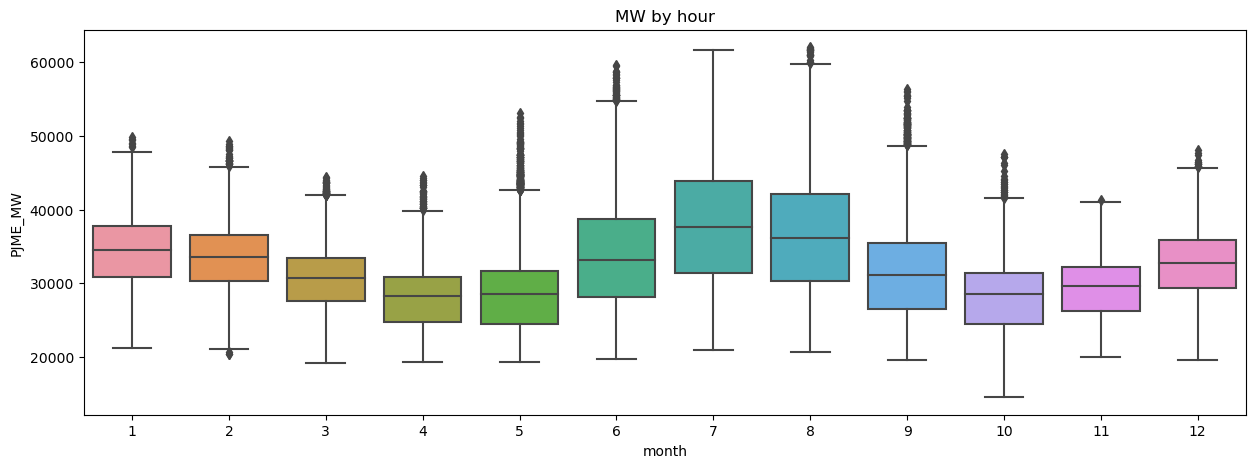

In [122]:
fig,ax=plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x="month",y="PJME_MW")
ax.set_title("MW by hour")

Tho peaks here show the summer AC crave and winder heater crave

# Create model

In [123]:
train = create_features(train)
test = create_features(test)

l = df.keys().to_list()
l.remove("PJME_MW")
FEATURES = l
TARGET = "PJME_MW"
print(FEATURES)
print(TARGET)

['hour', 'dayofweek', 'month', 'year', 'quarter', 'dayofyear']
PJME_MW


In [124]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [125]:
reg = xgb.XGBRegressor(n_estimators=1000,
                       early_stopping_rounds=50, # prevents overfitting
                       learning_rate = 0.01
                       )
reg.fit(X_train, y_train, 
        eval_set=[(X_train,y_train), (X_test,y_test)],
        verbose=5)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.26256
[5]	validation_0-rmse:31024.14316	validation_1-rmse:30075.79851


[10]	validation_0-rmse:29524.66621	validation_1-rmse:28571.71466
[15]	validation_0-rmse:28099.33236	validation_1-rmse:27143.89541
[20]	validation_0-rmse:26744.75390	validation_1-rmse:25791.21342
[25]	validation_0-rmse:25457.49135	validation_1-rmse:24506.70819
[30]	validation_0-rmse:24234.04380	validation_1-rmse:23287.89239
[35]	validation_0-rmse:23071.66967	validation_1-rmse:22130.16353
[40]	validation_0-rmse:21967.27772	validation_1-rmse:21029.59270
[45]	validation_0-rmse:20918.17175	validation_1-rmse:19985.21383
[50]	validation_0-rmse:19921.59089	validation_1-rmse:18994.45339
[55]	validation_0-rmse:18974.61485	validation_1-rmse:18057.06743
[60]	validation_0-rmse:18074.96747	validation_1-rmse:17172.17320
[65]	validation_0-rmse:17220.99639	validation_1-rmse:16329.40439
[70]	validation_0-rmse:16410.00894	validation_1-rmse:15524.97974
[75]	validation_0-rmse:15640.12429	validation_1-rmse:14761.06444
[80]	validation_0-rmse:14909.45333	validation_1-rmse:14038.30096
[85]	validation_0-rmse:14

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<AxesSubplot: title={'center': 'Feature importnace'}>

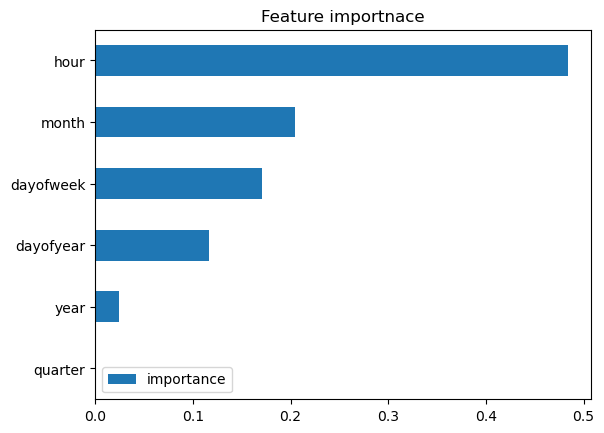

In [126]:
# Check feature importance with XGBoost
fi = pd.DataFrame(data=reg.feature_importances_,
                      index=reg.feature_names_in_,
                      columns=["importance"])
fi.sort_values("importance").plot(kind="barh",title="Feature importnace")
# SHows how much each feature was used when the trees were built

Most important features in building trees is hour and month
NOTE:  
_if features are very correlated_ this is not inforamtive

## Focasting on the test set

In [127]:
test["prediction"] = reg.predict(X_test)

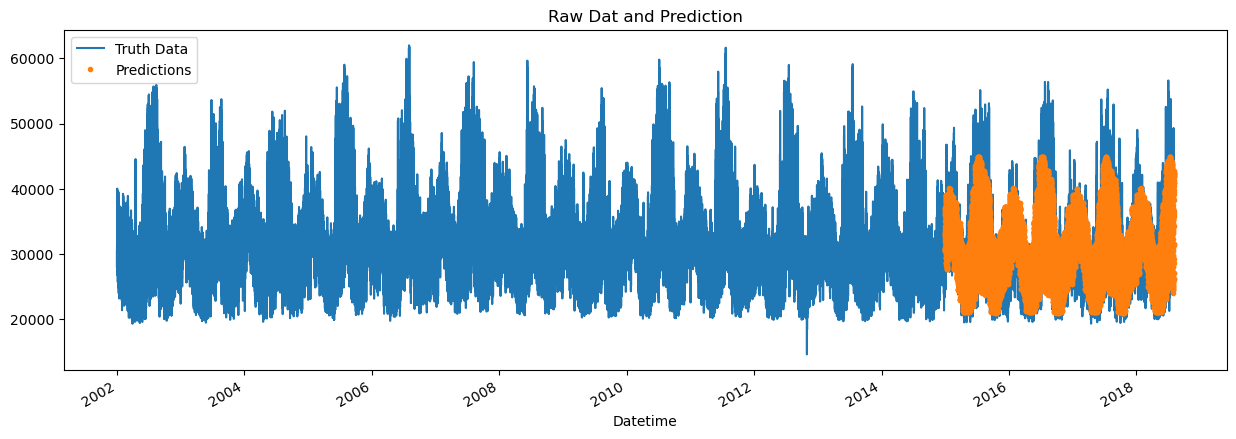

In [130]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

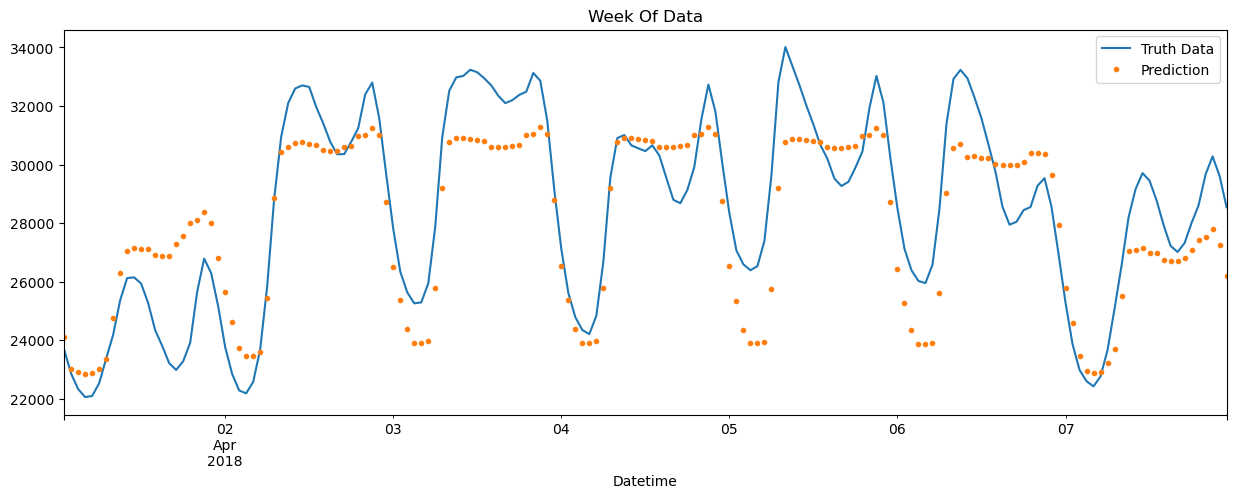

In [131]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Score (RMSE) and  Calculate Error

In [132]:

score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

RMSE Score on Test set: 3715.99


date
2016-08-13    14577.210124
2016-08-14    14472.472738
2016-09-10    12494.880941
2016-08-12    11525.418376
2016-09-09    11369.640299
2018-01-06    10903.514486
2015-02-20    10818.344727
2016-08-11    10390.962891
2018-01-07    10189.657715
2017-05-19    10180.837646
Name: error, dtype: float64

# Part 2

- Outlier analysis
- Forcasting horizon
- Time series cross-validation
- Lag Features
- Predict the Future

1. Outlier analysis. Some data at 2013 is too low to be real. It might be wrong. 

<AxesSubplot: ylabel='Frequency'>

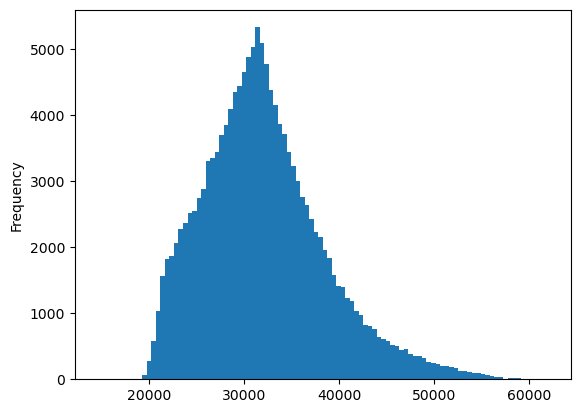

In [136]:
# Read the new Data frame
df = pd.read_csv("./PJME_hourly.csv",index_col=0)
df.index = pd.to_datetime(df.index)
#df.set_index("Datetime")
df.head()

df["PJME_MW"].plot(kind="hist",bins=100)

<AxesSubplot: xlabel='Datetime'>

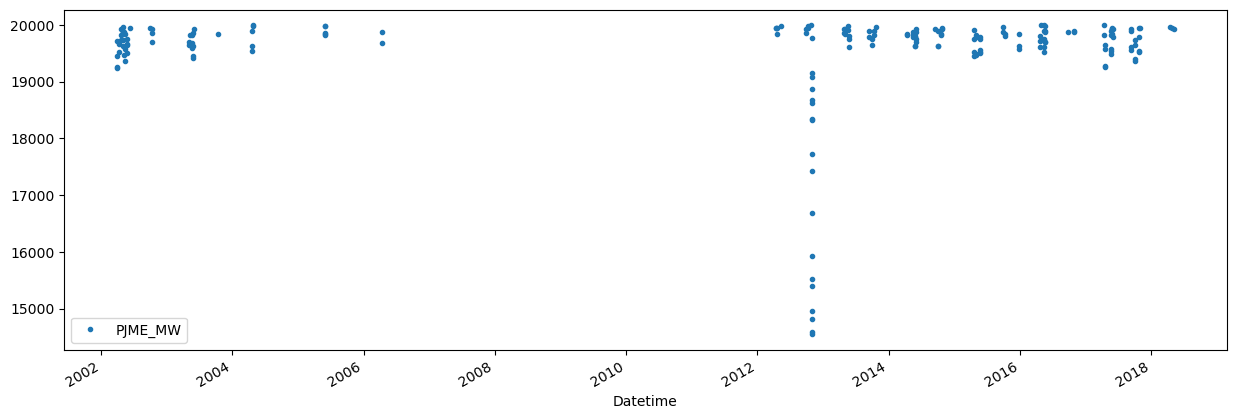

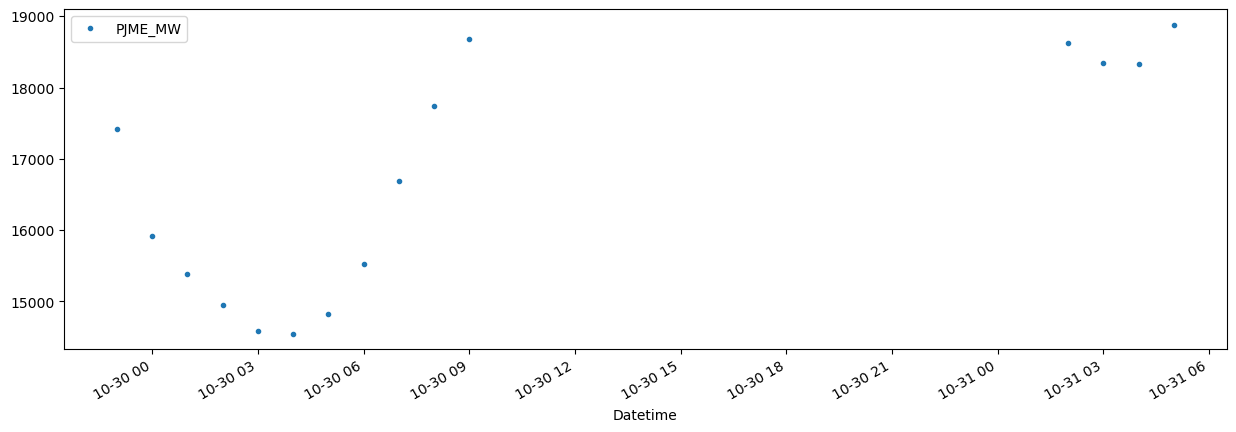

In [138]:
# Consider an extreme outliers
df.query("PJME_MW < 20_000").plot(figsize=(15,5),style='.')
df.query("PJME_MW < 19_000").plot(figsize=(15,5),style='.')

> It seems that there are outliers in 2013 for some reason

In [139]:
# Removing outliers 
df = df.query("PJME_MW > 19_000").copy()

In [144]:
# Cross validation with TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5,
                      test_size=24*365*1, # 1 year prediction into the future
                      gap=24 # 24 hours in between  cv and test splits
                      )
df = df.sort_index()


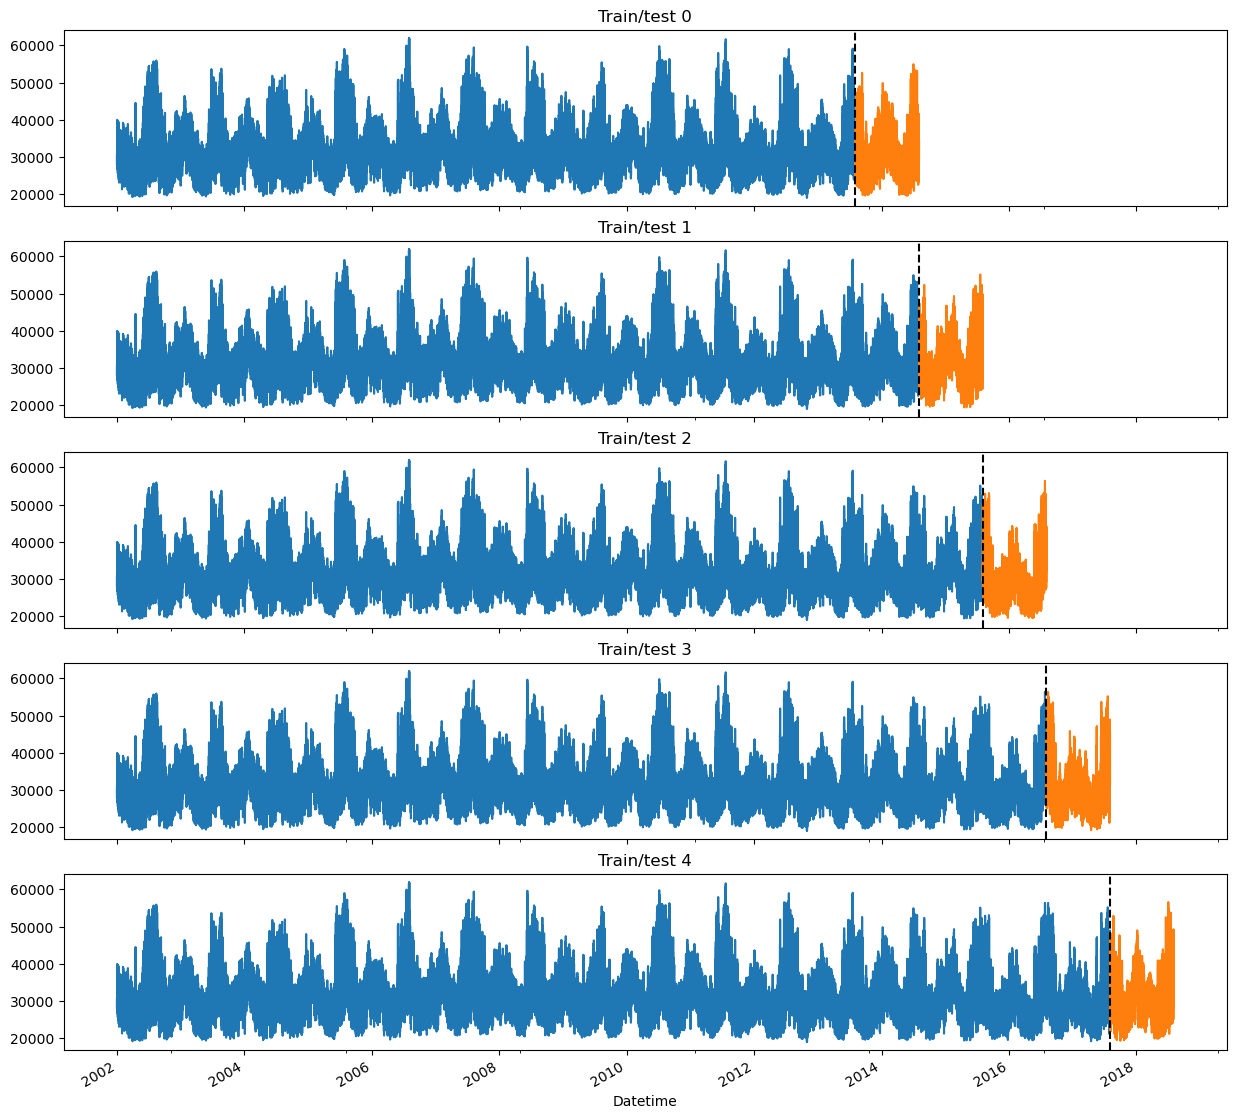

In [145]:
# Apply generator to get indeces (N loops = n_splits)
fig, axs = plt.subplots(5,1,figsize=(15,15),sharex="all")
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train["PJME_MW"].plot(ax=axs[fold],label="train",title=f"Train/test {fold}")
    test["PJME_MW"].plot(ax=axs[fold],label="test")
    axs[fold].axvline(test.index.min(),color="black",ls="--")
    fold+=1

# go back five years and 


### Forcasting Horizon

### Lag features 
- Can only be added up to the time horizon

Target variable at a given time in the past as a new feature of the model... 


In [147]:
target_map = df["PJME_MW"].to_dict() # for mapping
# Set same day last year
df.index - pd.Timedelta("364 days") # substruct (364/7) so it will give the exact same day of the week
# map it on our target varaible 
# It must be SHORTER than the forcasting horizon
def add_lags(df):
    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    return df

In [155]:
df = create_features(df)
df = add_lags(df)

In [156]:
df.head() # Empty lags as there is nothing in the histroy for the eary days

,PJME_MW,lag1,lag2,lag3,hour,dayofweek,month,year,quarter,dayofyear
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,NaN,NaN,NaN,1,1,1,2002,1,1
2002-01-01 02:00:00,29265.0,NaN,NaN,NaN,2,1,1,2002,1,1
2002-01-01 03:00:00,28357.0,NaN,NaN,NaN,3,1,1,2002,1,1
2002-01-01 04:00:00,27899.0,NaN,NaN,NaN,4,1,1,2002,1,1
2002-01-01 05:00:00,28057.0,NaN,NaN,NaN,5,1,1,2002,1,1


In [157]:
df.tail() # Lag features are present here

,PJME_MW,lag1,lag2,lag3,hour,dayofweek,month,year,quarter,dayofyear
Datetime,,,,,,,,,,
2018-08-02 20:00:00,44057.0,42256.0,41485.0,38804.0,20,3,8,2018,3,214
2018-08-02 21:00:00,43256.0,41210.0,40249.0,38748.0,21,3,8,2018,3,214
2018-08-02 22:00:00,41552.0,39525.0,38698.0,37330.0,22,3,8,2018,3,214
2018-08-02 23:00:00,38500.0,36490.0,35406.0,34552.0,23,3,8,2018,3,214
2018-08-03 00:00:00,35486.0,33539.0,32094.0,31695.0,0,4,8,2018,3,215


In [161]:
# Loop over cross-validation folds and train the model for each
y_preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    keys_train = train.keys().to_list()
    target = "PJME_MW"
    keys_train.remove(target)
    print(keys_train)
    X_train = train[keys_train]
    y_train = train[target]

    X_test = test[keys_train]
    y_test = test[target]

    reg = xgb.XGBRegressor(base_score=0.5,
                           booster="gbtree",
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective="reg:linear",
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],verbose=100)
    y_pred = reg.predict(X_test)
    y_preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test,y_pred))
    scores.append(score)

['lag1', 'lag2', 'lag3', 'hour', 'dayofweek', 'month', 'year', 'quarter', 'dayofyear']
[16:58:51] WARNING: /croot/xgboost-split_1675457761144/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32732.50147	validation_1-rmse:31956.66494
[100]	validation_0-rmse:12532.10915	validation_1-rmse:11906.70125
[200]	validation_0-rmse:5739.78666	validation_1-rmse:5352.86754
[300]	validation_0-rmse:3868.29390	validation_1-rmse:3891.32148
[400]	validation_0-rmse:3428.85875	validation_1-rmse:3753.95996
[456]	validation_0-rmse:3349.18480	validation_1-rmse:3761.64093
['lag1', 'lag2', 'lag3', 'hour', 'dayofweek', 'month', 'year', 'quarter', 'dayofyear']
[16:59:02] WARNING: /croot/xgboost-split_1675457761144/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32672.16154	validation_1-rmse:32138.88680
[100]	validation_0-rmse:12513.25338	validation_1-rmse:12222.9762

In [162]:
# Parameter tunning should imporve scores across ALL folds
print(f"Score across folds = {np.mean(scores):0.4f}")
print(f"Fold scores:{scores}")

Score across folds = 3750.7137
Fold scores:[3753.2775219986684, 3434.3528874818867, 3475.9138463312997, 4093.7260445492084, 3996.298054855067]


# Predicting into the future
- Create sceleton 

In [163]:
# Final training on all the data

keys_train = df.keys().to_list()
target = "PJME_MW"
keys_train.remove(target)
print(keys_train)
X_all = df[keys_train]
y_all = df[target]

reg = xgb.XGBRegressor(base_score=0.5,
                           booster="gbtree",
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective="reg:linear",
                           max_depth=3,
                           learning_rate=0.01)
reg.fit(X_all,y_all,eval_set=[(X_all,y_all)],verbose=100)


['lag1', 'lag2', 'lag3', 'hour', 'dayofweek', 'month', 'year', 'quarter', 'dayofyear']
[17:05:27] WARNING: /croot/xgboost-split_1675457761144/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32403.88753
[100]	validation_0-rmse:12426.44700
[200]	validation_0-rmse:5752.69704
[300]	validation_0-rmse:3970.08787
[400]	validation_0-rmse:3569.37848
[500]	validation_0-rmse:3453.91141
[600]	validation_0-rmse:3401.16957
[700]	validation_0-rmse:3364.74781
[800]	validation_0-rmse:3335.24875
[900]	validation_0-rmse:3307.77800
[999]	validation_0-rmse:3283.27077


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [166]:
# Create new dates with 
future = pd.date_range("2018-08-03","2019-08-01", freq="1h")

In [167]:
future_df = pd.DataFrame(index=future)
future_df["isFuture"] = True
df["isFuture"] = False
df_and_future = pd.concat([df,future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [168]:
future_w_features = df_and_future.query("isFuture").copy()

In [169]:
# Predict the future 
future_w_features["pred"] = reg.predict(future_w_features[keys_train])


<AxesSubplot: title={'center': 'Future Prediction'}>

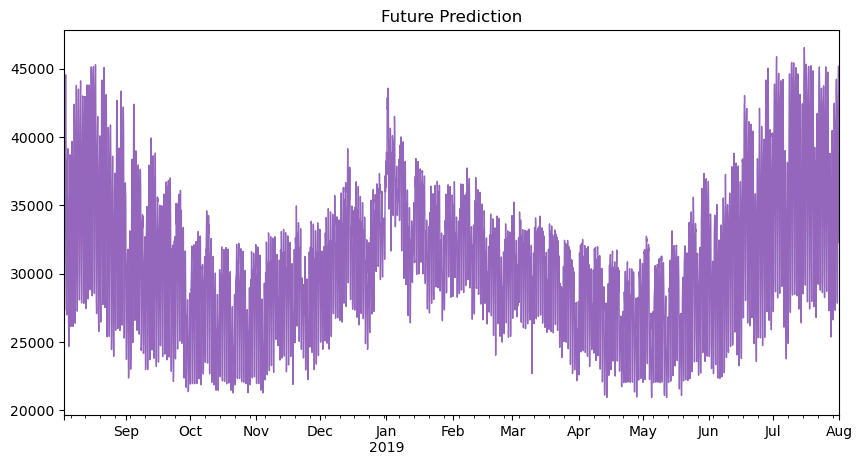

In [170]:
future_w_features["pred"].plot(figsize=(10,5),color=color_pal[4],ms=1,lw=1,title="Future Prediction")

In [171]:
# Saving XGBmodel
reg.save_model("model.json")


In [172]:
reg = xgb.XGBRegressor()
reg.load_model("model.json")

# Forecast Using Prophet

In [18]:
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")
plt.style.use("ggplot")
plt.style.use("fivethirtyeight")


In [5]:
def mean_absolute_percentage_error(y_true,y_pred):
    "calc MAPE Average percent with respect to the trues "
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true)) * 100

In [6]:
# Read data
pjme = pd.read_csv("./PJME_hourly.csv",
                   index_col=[0],
                   parse_dates=[0])
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


<AxesSubplot: title={'center': 'PJME'}, xlabel='Datetime'>

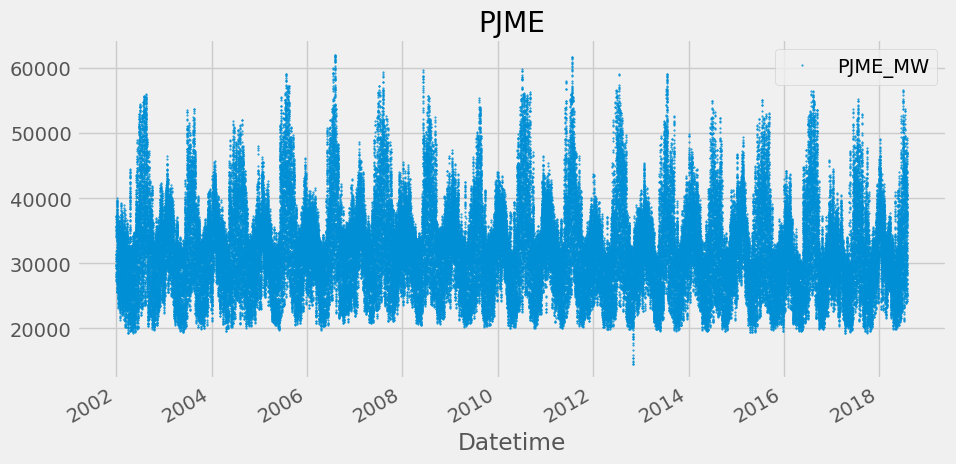

In [7]:
color_pal = sns.color_palette()
pjme.plot(style='.',figsize=(10,5),color=color_pal[0],title="PJME",ms=1)

In [8]:
# Visualize trends MAKE TIMESERIES FETUES
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)

In [9]:
features_and_target.head()


,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,PJME_MW
Datetime,,,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,Tuesday,Winter,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,Tuesday,Winter,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,Tuesday,Winter,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,Tuesday,Winter,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,Tuesday,Winter,24860.0


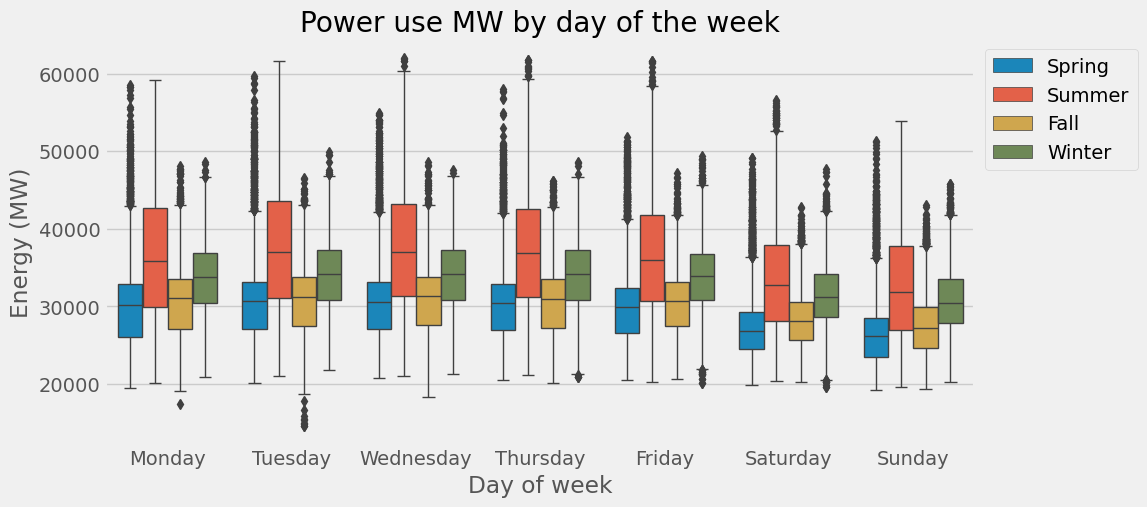

In [13]:
fig,ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=features_and_target.dropna(),
             x="weekday",
             y="PJME_MW",
             hue="season",
             linewidth=1)
ax.set_title("Power use MW by day of the week")
ax.set_xlabel("Day of week")
ax.set_ylabel("Energy (MW)")
ax.legend(bbox_to_anchor=(1,1))
plt.show()


NOTES:  
Day of the week is importnat (really?..)
Season is very important!
                              

>  No cross-validation split done here for brevity!
### Train / test split

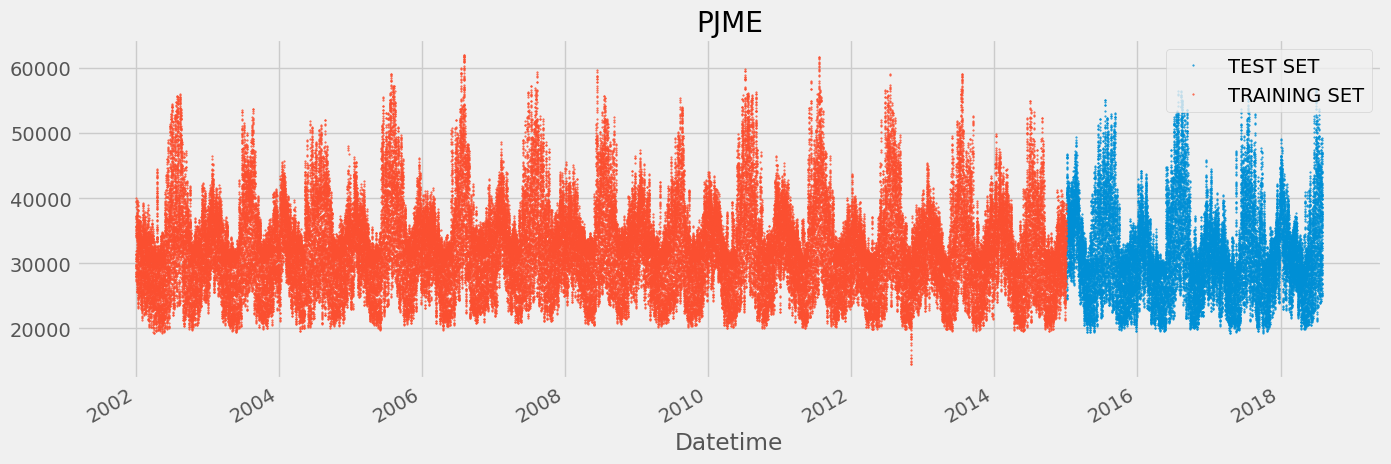

In [15]:
split_day = "1-Jan-2015"
pjme_train = pjme.loc[pjme.index <= split_day].copy()
pjme_test = pjme.loc[pjme.index > split_day].copy()

# plot data
pjme_test \
    .rename(columns={"PJME_MW":"TEST SET"}) \
    .join(pjme_train.rename(columns={"PJME_MW":"TRAINING SET"}),
          how="outer") \
    .plot(figsize=(15,5),title="PJME", style=".", ms=1)
plt.show()


### Train Phorphet model
- Expects data in a specific format:
- Datetime column name must be `ds`
- Target must be named `y`

In [17]:
pjme_train_phophet = pjme_train.reset_index() \
    .rename(columns={"Datetime":"ds","PJME_MW":"y"})
pjme_train_phophet.head()

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [19]:
%%time
model = Prophet()
model.fit(pjme_train_phophet)

08:43:55 - cmdstanpy - INFO - Chain [1] start processing
08:44:37 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 4.36 s, sys: 201 ms, total: 4.56 s
Wall time: 47.2 s


In [20]:
pjme_test_prophet = pjme_test.reset_index() \
    .rename(columns={"Datetime":"ds",
                     "PJME_MW":"y"})
pjme_test_fcast = model.predict(pjme_test_prophet)

In [21]:
pjme_test_fcast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31196.569737,24066.039590,32853.509465,31196.569737,31196.569737,-2832.039685,-2832.039685,-2832.039685,-4430.340618,...,1281.401850,1281.401850,1281.401850,316.899083,316.899083,316.899083,0.0,0.0,0.0,28364.530052
1,2015-01-01 02:00:00,31196.530226,22527.335231,31195.252687,31196.530226,31196.530226,-4336.382472,-4336.382472,-4336.382472,-5927.234241,...,1272.642609,1272.642609,1272.642609,318.209160,318.209160,318.209160,0.0,0.0,0.0,26860.147754
2,2015-01-01 03:00:00,31196.490715,21651.122802,30508.082798,31196.490715,31196.490715,-5208.068991,-5208.068991,-5208.068991,-6790.307358,...,1262.677669,1262.677669,1262.677669,319.560697,319.560697,319.560697,0.0,0.0,0.0,25988.421725
3,2015-01-01 04:00:00,31196.451205,21567.614780,30629.468226,31196.451205,31196.451205,-5349.632017,-5349.632017,-5349.632017,-6922.216362,...,1251.630624,1251.630624,1251.630624,320.953721,320.953721,320.953721,0.0,0.0,0.0,25846.819188
4,2015-01-01 05:00:00,31196.411694,22167.828192,30634.766809,31196.411694,31196.411694,-4675.310856,-4675.310856,-4675.310856,-6237.336387,...,1239.637275,1239.637275,1239.637275,322.388256,322.388256,322.388256,0.0,0.0,0.0,26521.100838


NOTE:  
Prophet is an `additive` model, so it saves each of the component of the prediction `yhat`. 

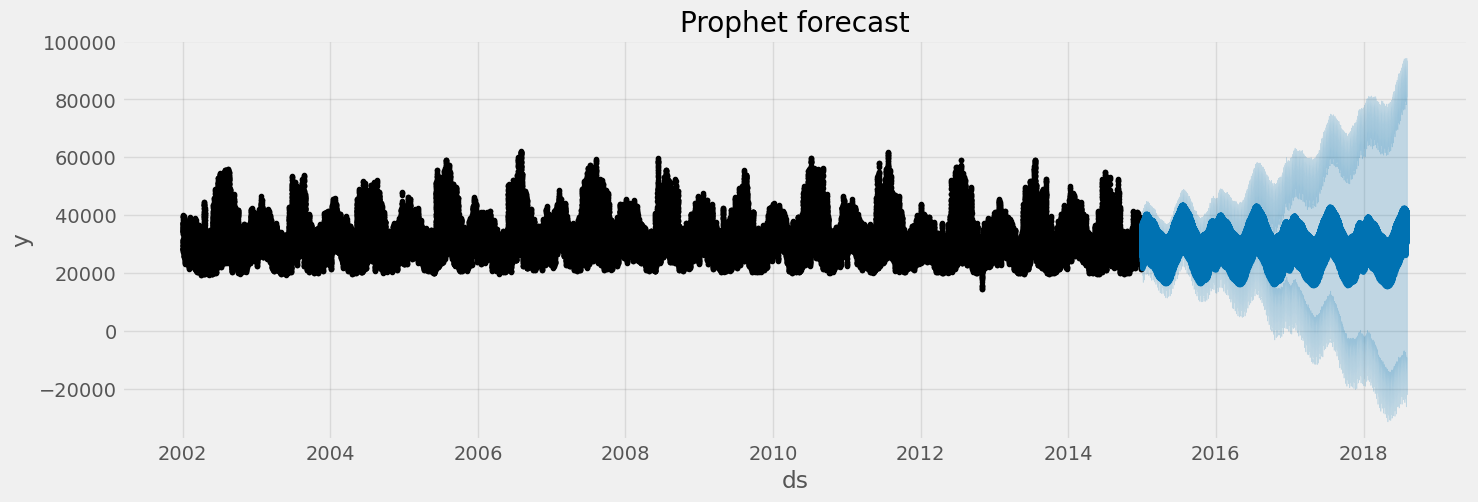

In [24]:
fig, ax = plt.subplots(figsize=(15,5))
fig = model.plot(pjme_test_fcast, ax=ax)
ax.set_title("Prophet forecast")
plt.show()

Confidence intervals becomes wider as we go further into the future

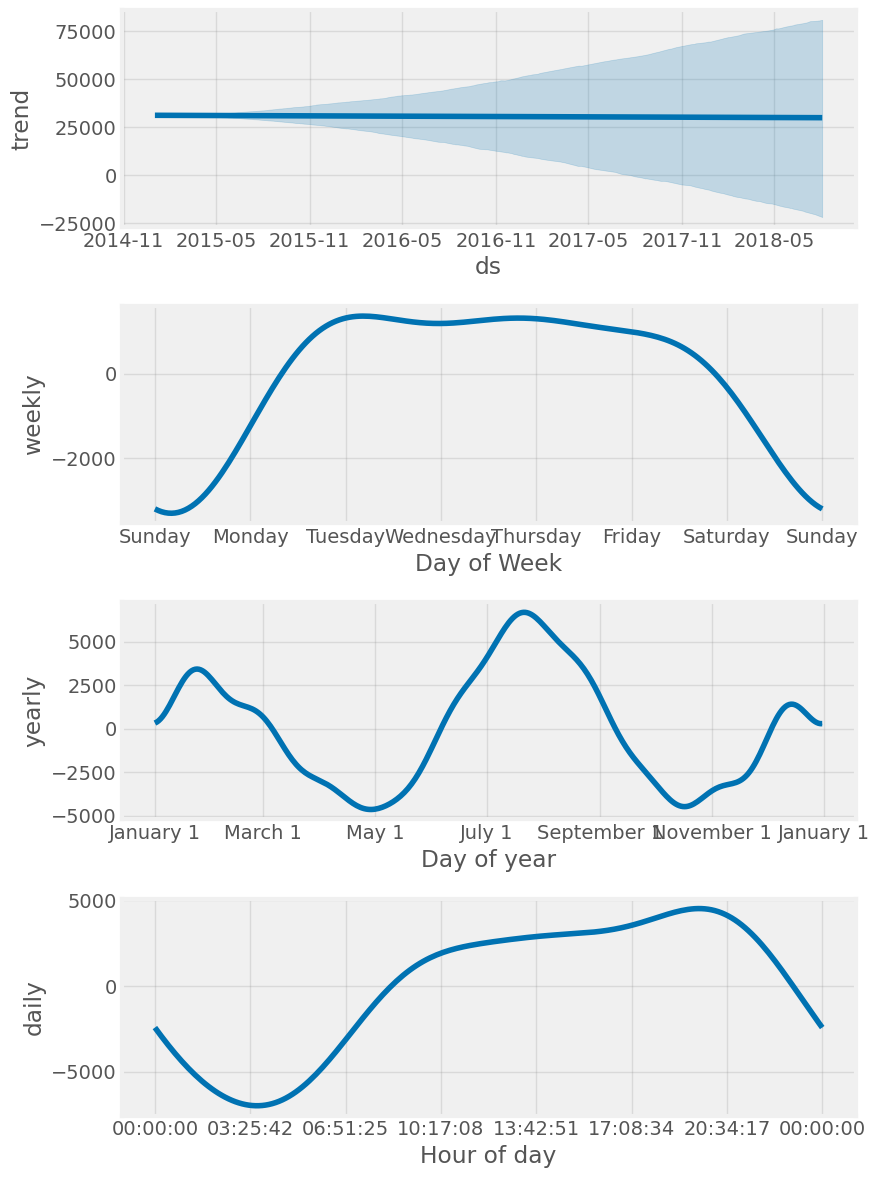

In [25]:
# Plotting the components of the model
model.plot_components(pjme_test_fcast)
plt.show()

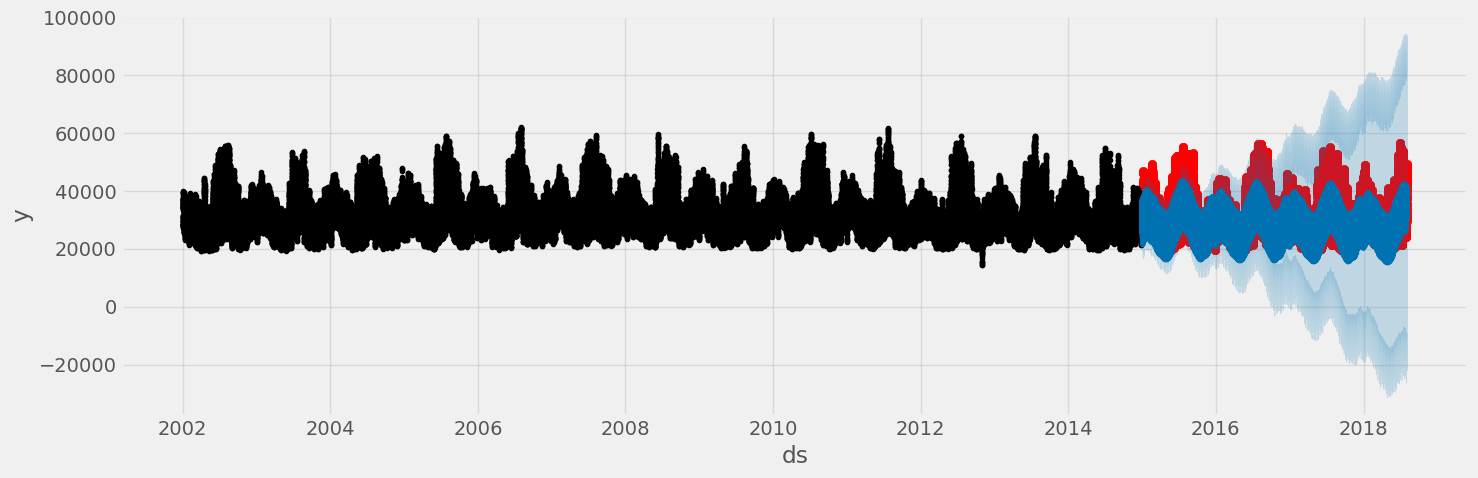

In [26]:

f, ax = plt.subplots(figsize=(15,5))
ax.scatter(pjme_test.index, pjme_test["PJME_MW"],color='r')
fig = model.plot(pjme_test_fcast,ax=ax)

ConversionError: Failed to convert value(s) to axis units: '01-01-2015'

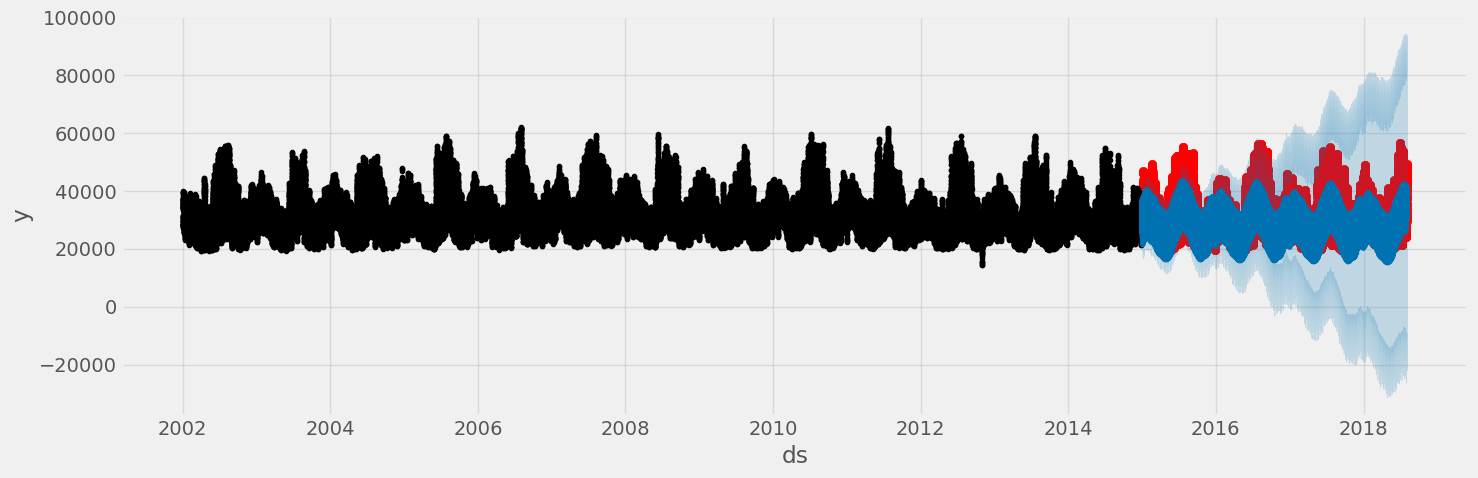

In [40]:

# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcast, ax=ax)
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
ax.set_title('First Week of January Forecast vs Actuals')
plt.show()

ConversionError: Failed to convert value(s) to axis units: '01-01-2015'

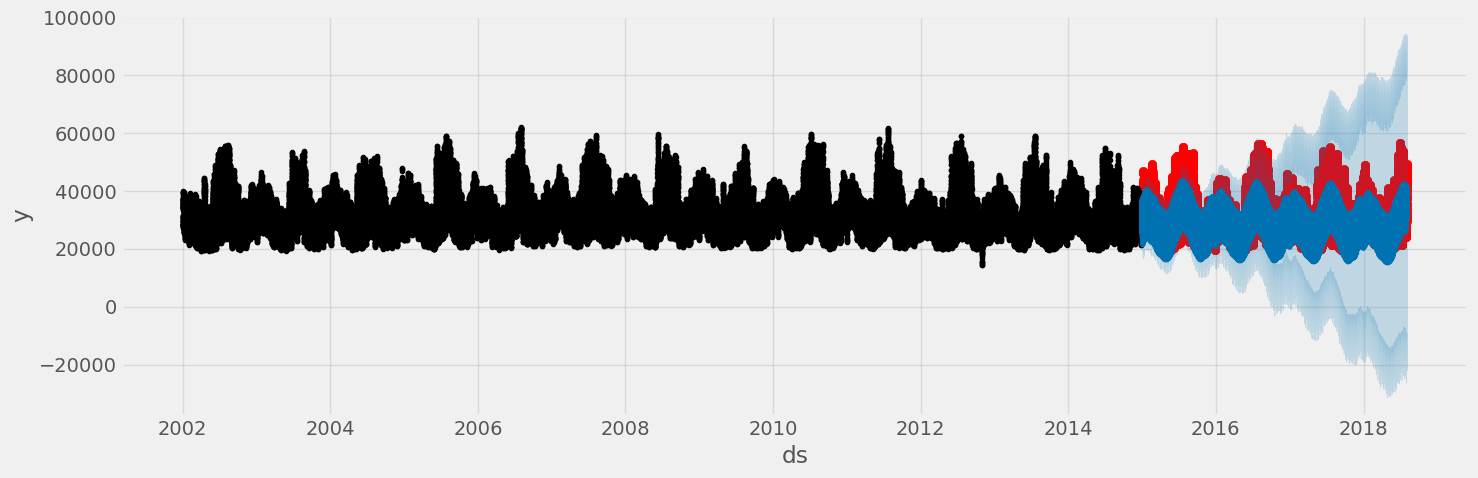

In [37]:
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(pjme_test.index, pjme_test["PJME_MW"],color='r')
fig = model.plot(pjme_test_fcast,ax=ax)
ax.set_xbound(lower="01-01-2015",
              upper='01-08-2015')
# ax.set_xlim([datetime.date(2015, 1, 1), datetime.date(2015, 2, 1)])
ax.set_ylim(0,60000)
plot=plt.suptitle("Jan 2015 forcast vs actuals")

# Evaluate with metrix

In [46]:
mse = np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcast['yhat']))
mae = mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcast['yhat'])
mape = mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcast['yhat'])

print(f"MSE={mse} MAE={mae} MAPE={mape}")

MSE=6620.122629528544 MAE=5184.237000062714 MAPE=16.503231552883825


# Avoiding holidays

In [47]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()


holidays = cal.holidays(start=pjme.index.min(),
                        end=pjme.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})


In [50]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_test_prophet)

09:16:54 - cmdstanpy - INFO - Chain [1] start processing
09:17:08 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 1.42 s, sys: 72.1 ms, total: 1.5 s
Wall time: 15.1 s


In [51]:
# Predict on training set with model
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test_prophet)

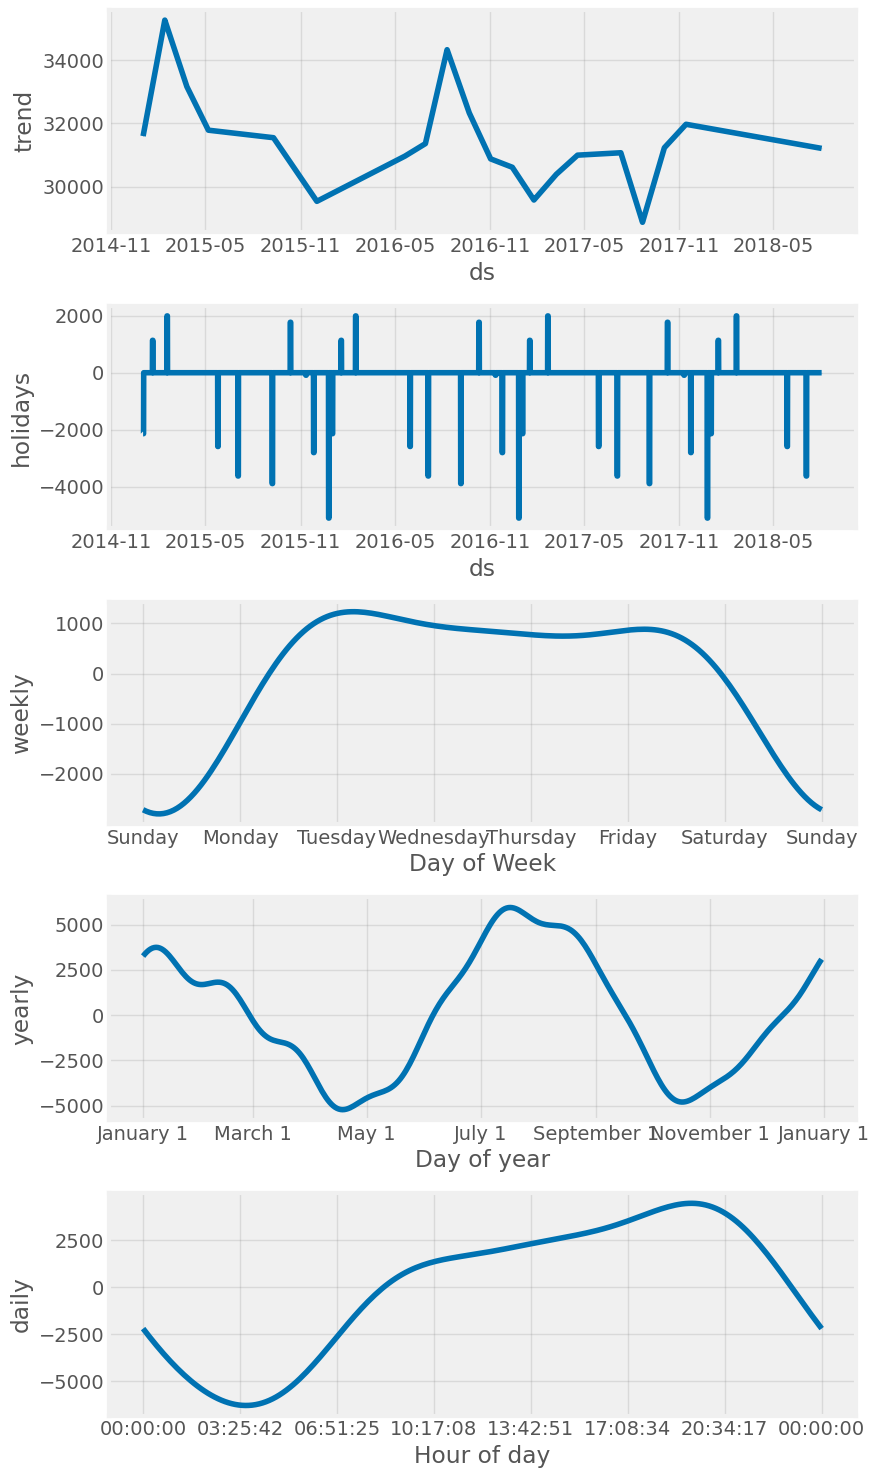

In [52]:
fig = model_with_holidays.plot_components(
    pjme_test_fcst_with_hols)
plt.show()

ConversionError: Failed to convert value(s) to axis units: '07-01-2015'

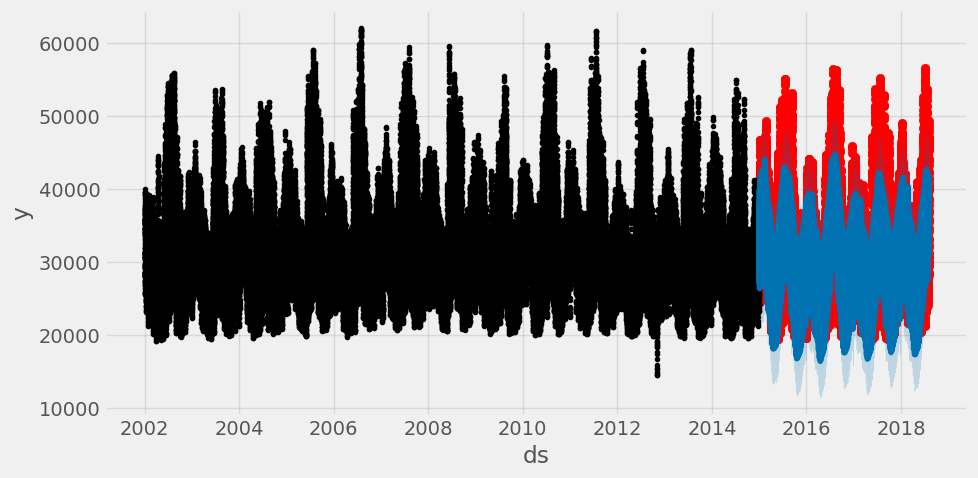

In [53]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst_with_hols, ax=ax)
ax.set_xbound(lower='07-01-2015',
              upper='07-07-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('July 4 Predictions vs Actual')

# Predict into the Future


In [54]:
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)
forecast = model_with_holidays.predict(future)

In [55]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2015-01-01 01:00:00,29423.480551
1,2015-01-01 02:00:00,28076.486668
2,2015-01-01 03:00:00,27287.921038
3,2015-01-01 04:00:00,27191.032862
4,2015-01-01 05:00:00,27884.072472



f, ax = plt.subplots(figsize=(15,5))
ax.scatter(pjme_test.index, pjme_test["PJME_MW"],color='r')
fig = model.plot(pjme_test_fcast,ax=ax)